In [1]:
!pip install torch transformers pandas scikit-learn cirpy rdkit-pypi

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 12.3 MB/s eta 0:00:00
  Created wheel for cirpy: filename=CIRpy-1.0.2-py3-none-any.whl size=7263 sha256=c9c97c3c4ed943dfa2946370216629d03f4e3d4dc9725def22fe803d5df37526
  Stored in directory: /root/.cache/pip/wheels/c7/35/2b/f5d2226974fb5b1e84d53eda475d8b33a38548a6b25e32c2c0
Successfully built cirpy


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import cirpy
import scipy
import torch
import torch.nn.functional as F
import math

from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import CalcNumAtomStereoCenters
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.PandasTools import WriteSDF
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

In [4]:
df = pd.read_csv('Dataset_oxidation.csv')
df = df.drop(columns=['Unnamed: 0', 'name', 'solvent_ox_smiles',
       'reference electrode', 'label', 'E_ox', 'E_ox_adj'])

df['potential_bin'] = pd.qcut(df['E_ox_adj_mean'], q=10, labels=False)

In [5]:
def split_stratified_into_train_val_test(df_input, stratify_colname='potential_bin',
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15,
                                         random_state=42):

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input
    y = df_input[[stratify_colname]]

    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test

In [6]:
df_train, df_val, df_test = split_stratified_into_train_val_test(df, stratify_colname='potential_bin',
                                                                 frac_train=0.70, frac_val=0.15, frac_test=0.15)

In [7]:
model = AutoModel.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct", trust_remote_code=True
)
model_name = "MolFormer_10pct"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
class MolformerForRegression(torch.nn.Module):
    def __init__(self, model):
        super(MolformerForRegression, self).__init__()
        self.molformer = model
        self.regressor = torch.nn.Linear(model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.molformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Take the [CLS] token's representation
        regression_output = self.regressor(cls_output)
        return regression_output

molformer_model = MolformerForRegression(model)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
molformer_model.to(device)

MolformerForRegression(
  (molformer): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [11]:
class SMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        smiles = self.dataframe.iloc[idx]['smiles']
        redox_potential = self.dataframe.iloc[idx]['E_ox_adj_mean']

        inputs = self.tokenizer(smiles, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
        inputs = {key: val.squeeze() for key, val in inputs.items()}

        return inputs, torch.tensor(redox_potential, dtype=torch.float).to(device)

train_dataset = SMILESDataset(df_train, tokenizer)
val_dataset = SMILESDataset(df_val, tokenizer)
test_dataset = SMILESDataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

<ipython-input-12-e3bb2b133f0e>:43: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.squeeze(), labels)


Epoch 1, Train Loss: 0.9230, Val Loss: 0.3017
Epoch 2, Train Loss: 0.3158, Val Loss: 0.1695
Epoch 3, Train Loss: 0.2292, Val Loss: 0.1418
Epoch 4, Train Loss: 0.1697, Val Loss: 0.1159
Epoch 5, Train Loss: 0.1216, Val Loss: 0.1246
Epoch 6, Train Loss: 0.1301, Val Loss: 0.1186
Epoch 7, Train Loss: 0.1078, Val Loss: 0.0852
Epoch 8, Train Loss: 0.0838, Val Loss: 0.1048
Epoch 9, Train Loss: 0.0819, Val Loss: 0.0945
Epoch 10, Train Loss: 0.0844, Val Loss: 0.0926
Epoch 11, Train Loss: 0.0857, Val Loss: 0.1126
Epoch 12, Train Loss: 0.0711, Val Loss: 0.1075
Epoch 13, Train Loss: 0.0683, Val Loss: 0.0900
Epoch 14, Train Loss: 0.0627, Val Loss: 0.0925
Epoch 15, Train Loss: 0.0545, Val Loss: 0.0902
Epoch 16, Train Loss: 0.0658, Val Loss: 0.0791
Epoch 17, Train Loss: 0.0464, Val Loss: 0.1203
Epoch 18, Train Loss: 0.0564, Val Loss: 0.0881
Epoch 19, Train Loss: 0.0547, Val Loss: 0.0951
Epoch 20, Train Loss: 0.0632, Val Loss: 0.0829
Epoch 21, Train Loss: 0.0523, Val Loss: 0.0784
Epoch 22, Train Loss: 

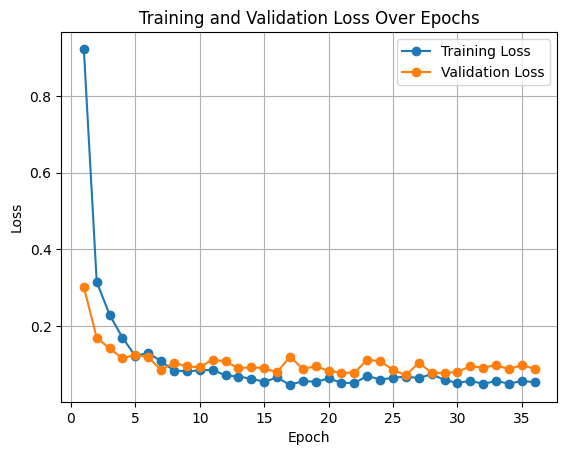

In [12]:
optimizer = torch.optim.AdamW(molformer_model.parameters(), lr=1e-5)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=5)

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_loss_values = []
val_loss_values = []

molformer_model.train()
for epoch in range(num_epochs):
    total_train_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs['input_ids'] = inputs['input_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = molformer_model(**inputs)
        loss = F.mse_loss(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    # Validation step
    molformer_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['attention_mask'] = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            outputs = molformer_model(**inputs)
            loss = F.mse_loss(outputs.squeeze(), labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': molformer_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, f'model_epoch_{epoch + 1}.pth')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': molformer_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    molformer_model.train()

plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o', label='Training Loss')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


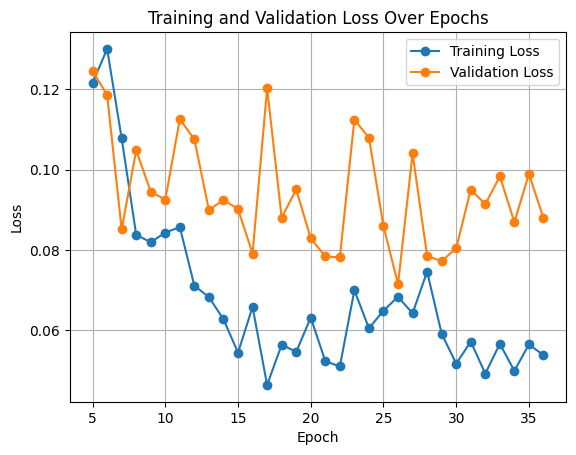

In [13]:
plt.plot(range(5, len(train_loss_values) + 1), train_loss_values[4:], marker='o', label='Training Loss')
plt.plot(range(5, len(val_loss_values) + 1), val_loss_values[4:], marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
molformer_model_loaded = torch.load('model_epoch_30.pth')

In [67]:
molformer_model_for_eval = MolformerForRegression(model)

In [68]:
molformer_model_for_eval.load_state_dict(molformer_model_loaded['model_state_dict'])

<All keys matched successfully>

In [69]:
molformer_model_for_eval.eval()
predictions = []
true_values = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs['input_ids'] = inputs['input_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        outputs = molformer_model(**inputs)
        #print(outputs.tolist())
        predictions.extend(outputs.tolist())
        true_values.extend(labels.tolist())
predictions = sum(predictions, [])

mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)
print(f'Test MSE: {mse:.4f}, Test RMSE: {math.sqrt(mse):.4f}, Test R^2: {r2:.4f}')

Test MSE: 0.1115, Test RMSE: 0.3339, Test R^2: 0.6652


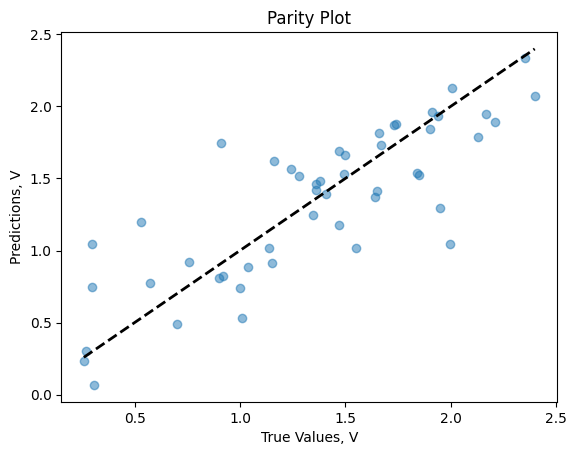

In [70]:
def parity_plot(preds, targets):
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'k--', lw=2)
    plt.xlabel('True Values, V')
    plt.ylabel('Predictions, V')
    plt.title('Parity Plot')
    plt.show()

parity_plot(predictions, true_values)

In [71]:
errors = np.abs(np.array(predictions) - np.array(true_values))

worst_indices = np.argsort(errors)[-5:]
print("Worst predictions:")
for idx in worst_indices:
    print(f"SMILES: {df['smiles'][idx]}, True: {true_values[idx]}, Predicted: {predictions[idx]}, Error: {errors[idx]}")

Worst predictions:
SMILES: Cc1cc(C)c(O)c(C)c1, True: 1.9490000009536743, Predicted: 1.2919646501541138, Error: 0.6570353507995605
SMILES: C=Cc1ccccc1, True: 0.5299999713897705, Predicted: 1.1990021467208862, Error: 0.6690021753311157
SMILES: C1CC=CC1, True: 0.29899999499320984, Predicted: 1.0477690696716309, Error: 0.748769074678421
SMILES: C/C=C/c1cccc(Cl)c1, True: 0.9089999794960022, Predicted: 1.7433507442474365, Error: 0.8343507647514343
SMILES: COc1ccc(cc1)C#C, True: 1.9989999532699585, Predicted: 1.0468052625656128, Error: 0.9521946907043457


In [72]:
best_indices = np.argsort(errors)[:5]

print("Best predictions:")
for idx in best_indices:
    print(f"SMILES: {df['smiles'][idx]}, True: {true_values[idx]}, Predicted: {predictions[idx]}, Error: {errors[idx]}")

Best predictions:
SMILES: Cc1ccccc1C, True: 1.940000057220459, Predicted: 1.932946801185608, Error: 0.007053256034851074
SMILES: C1CC2CC1C=C2, True: 2.3545000553131104, Predicted: 2.3372392654418945, Error: 0.01726078987121582
SMILES: COc1ccc(C=C)cc1OC, True: 1.409999966621399, Predicted: 1.3904590606689453, Error: 0.019540905952453613
SMILES: c1ccc2ccccc2c1, True: 0.2590000033378601, Predicted: 0.2331838309764862, Error: 0.0258161723613739
SMILES: Oc1ccc(Br)cc1, True: 0.26899999380111694, Predicted: 0.3035331666469574, Error: 0.034533172845840454
